In [4]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [2]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """

    # Specify the ensemble member
    if era == "CMIP6": 
        member = "r1i1p1f1"
    else:
        member = "r1i1p1"

    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
        member=member
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        print("Starting model: ", model)
        print("Model path: ", model_path)

        try:
            # Load data
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["rsutcs", "rsut", "tos"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=TESTING,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)
            if calc_anoms:
                ds.to_netcdf(f"data/{var}_mon_1850-2100_anoms_{era}_piControl.nc")
                ds.close()
            else: 
                ds.to_netcdf(f"data/{var}_mon_1850-2100_{era}_piControl.nc")
                ds.close()
                

        break


TESTING = False
collect_data()

Starting era:  CMIP6
Starting variable:  rsutcs
Starting model:  E3SM-1-1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201123/
Starting model:  E3SM-1-0
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/rsutcs/gr/v20190719/
Starting model:  E3SM-1-1-ECA
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201204/
Starting model:  KIOST-ESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Amon/rsutcs/gr1/v20210810/
Starting model:  CIESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/rsutcs/gr/v20200806/
Starting model:  BCC-ESM1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181214/
Starting model:  BCC-CSM2-MR
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181016/
St

KeyboardInterrupt: 

In [40]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_tos.keys()))
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
# print(shared_models)
print(dpaths_tos)
print(dpaths_rsus)
print(shared_models)

57
57
58
58
57
57
0 55
{'/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/': {'keyid': 'CMIP6.CMIP.E3SM-Project.E3SM-1-1.piControl.r1i1p1f1.Omon.ocean.mon.tos.gr.glb-2d-gr.v20201125', 'mip_era': 'CMIP6', 'activity': 'CMIP', 'institute': 'E3SM-Project', 'model': 'E3SM-1-1', 'experiment': 'piControl', 'member': 'r1i1p1f1', 'cmipTable': 'Omon', 'realm': 'ocean', 'frequency': 'mon', 'variable': 'tos', 'grid': 'gr', 'gridLabel': 'glb-2d-gr', 'version': 'v20201125', 'timepoints': 3012, 'nfiles': 51, 'nc_creation_date': '20191028', 'sumfilesize_bytes': 463466872, 'has_zero_size_files': 0, 'created': '2021-09-30 09:58:19', 'modified': '2020-11-30 17:01:27', 'accessed': '2022-10-04 14:34:56', 'retired': 0, 'retire_datetime': None, 'retracted': 0, 'retracted_datetime': None, 'ignored': 0, 'ignored_datetime': None, 'comment': None, 'unique': True, 'alternate_paths': ['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v201910

In [39]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_tos.keys()))
# print(dpaths_tos)
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
print(shared_models)

41
41
44
44
40
40
0 36
['NorESM1-M', 'GFDL-ESM2M', 'GISS-E2-H', 'MRI-CGCM3', 'IPSL-CM5A-LR', 'CNRM-CM5-2', 'bcc-csm1-1-m', 'CanESM2', 'MPI-ESM-LR', 'MIROC5', 'CESM1-FASTCHEM', 'NorESM1-ME', 'GISS-E2-R-CC', 'HadGEM2-CC', 'CCSM4', 'GFDL-CM3', 'CESM1-BGC', 'GISS-E2-H-CC', 'FIO-ESM', 'HadGEM2-ES', 'CSIRO-Mk3-6-0', 'inmcm4', 'bcc-csm1-1', 'BNU-ESM', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'CESM1-CAM5', 'MPI-ESM-P', 'ACCESS1-0', 'MIROC-ESM-CHEM', 'GFDL-ESM2G', 'ACCESS1-3', 'CNRM-CM5', 'MPI-ESM-MR', 'CESM1-WACCM']


In [11]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """
    
    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        if model != "CanESM5-1": continue
        import pdb; pdb.set_trace()
        try:
            print("Starting model: ", model)
            # Load data
            print(model_path)
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)
            continue

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["tos", "rsutcs", "rsut"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=False,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)

        break

collect_data()

Starting era:  CMIP6
Starting variable:  tos
> /tmp/ipykernel_35612/3542508154.py(36)ingest_and_process()
     34         if model != "CanESM5-1": continue
     35         import pdb; pdb.set_trace()
---> 36         try:
     37             print("Starting model: ", model)
     38             # Load data

CanESM5-1
CanESM5-1
/p/css03/esgf_publish/CMIP6/CMIP/MIROC/MIROC-ES2H/piControl/r1i1p4f2/Omon/tos/gn/v20220322/
['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Omon/tos/gr/v20200129/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Omon/tos/gr/v20201203/', '/p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Omon/tos/gr1/v20220204/', '/p/css03/scratch/cmip6/CMIP/THU/CIESM/piControl/r1i1p1f1/Omon/tos/gn/v20200220/', '/p/css03/esgf_publish/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/piControl/r1i1p1f2/Omon/tos/gn/v20191021/', '/p/css0

<xarray.DataArray 'lat' (lat: 4)>
array([-3.75, -1.25,  1.25,  3.75])
Coordinates:
  * lat      (lat) float64 -3.75 -1.25 1.25 3.75
    model    <U10 'bcc-csm1-1'


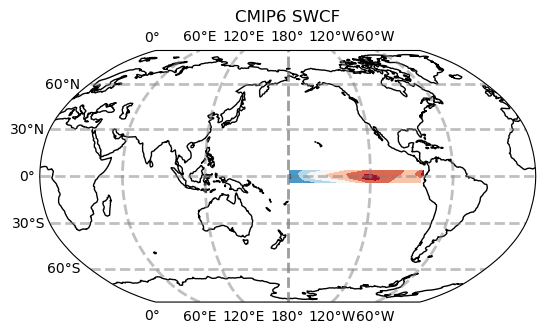

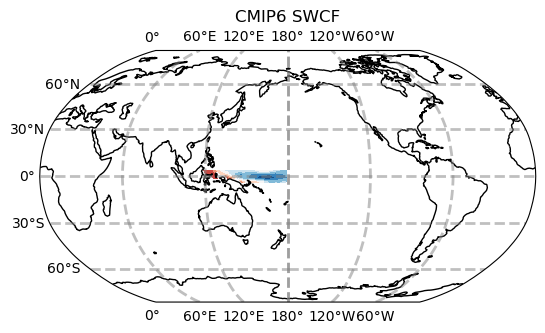

In [10]:
def global_plot(data, lon, lat, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    plt.show()

    
swcf_cmip6 = xr.open_dataarray(f"data/swcf_cmip5_monthly_1850-2000.nc", chunks="auto").to_dataset(name="swcf")
swcf_cmip6 = xc.swap_lon_axis(swcf_cmip6, to=(-180, 180))
swcf_east = swcf_cmip6.sel(lon=slice(-180, -80), lat=slice(-5, 5)).isel(model=14)
swcf_west = swcf_cmip6.sel(lon=slice(110, 180), lat=slice(-5, 5)).isel(model=14)
print(swcf_west.lat)

global_plot(lon=swcf_east.lon, lat=swcf_east.lat, data=swcf_east.swcf, cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcf_west.lon, lat=swcf_west.lat, data=swcf_west.swcf, cmap="RdBu_r", title="CMIP6 SWCF")
# swcf_cmip6.isel(model=1)

In [15]:
swcf_cmip6.close()

In [4]:
swcre_cmip6 = xr.open_dataset(f"data/swcre_cmip6_monthly_1850-2000.nc", chunks="auto") #.to_dataset(name="swcf")
swcre_cmip6 = xc.swap_lon_axis(swcre_cmip6, to=(-180, 180))
print(swcre_cmip6.lat)
# West pacific
swcre_west = swcre_cmip6.sel(lon=slice(130, 180), lat=slice(-7, 7)).isel(time=1,model=1)
# East pacific
swcre_east = swcre_cmip6.sel(lon=slice(-130, -80), lat=slice(-7, 7)).isel(time=1,model=1)

global_plot(lon=swcre_west.lon, lat=swcre_west.lat, data=swcre_west.swcre, cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcre_east.lon, lat=swcre_east.lat, data=swcre_east.swcre, cmap="RdBu_r", title="CMIP6 SWCF")

<xarray.DataArray 'lat' (lat: 72)>
array([-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25, -68.75,
       -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25, -48.75, -46.25,
       -43.75, -41.25, -38.75, -36.25, -33.75, -31.25, -28.75, -26.25, -23.75,
       -21.25, -18.75, -16.25, -13.75, -11.25,  -8.75,  -6.25,  -3.75,  -1.25,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    units:    degrees_north
    axis:     Y
    bounds:   lat_bnds


NameError: name 'global_plot' is not defined

In [15]:
swcre_anoms = xr.open_dataset(f"data/swcre_cmip6_anoms_monthly_1850-2000.nc", chunks="auto").mean("model")["swcre_anoms"]
tos_anoms = xr.open_dataset(f"data/tos_anoms_mon_1850-2100_CMIP6_piControl.nc", chunks="auto").mean("model")["tos"]
tos_anoms = tos_anoms.chunk({"time": -1})
swcre_anoms = swcre_anoms.chunk({"time": -1})

In [37]:
r = xscore.pearson_r(swcre_anoms, tos_anoms, dim="time")
p = xscore.pearson_r_p_value(swcre_anoms, tos_anoms, dim="time")

def fix_coords(data, var):
    data = data.rename(var).to_dataset().bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    data = data[var]
    return data

r = fix_coords(r, "r")
p = fix_coords(p, "p")


2023-06-22 09:10:15,956 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


2023-06-22 09:10:15,991 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


In [56]:
def global_plot_stippling(data, lon, lat, p, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        levels=np.arange(-.8, .9, 0.1),
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    ax1.contourf(
        lon, lat, p,
        transform=ccrs.PlateCarree(), colors='none', levels=[0, 0.05, 1],
        hatches=["...", ""]
    )
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()

In [57]:
global_plot_stippling(lon=swcre_cmip6.lon, lat=swcre_cmip6.lat, data=r, p=p, cmap="RdBu_r", title="CMIP6 r(SWCRE, SST)")

# Start development for Percentile based SST analysis

In [33]:
"""
Library to compute weighted quantiles, including the weighted median, of
numpy arrays.

https://github.com/nudomarinero/wquantiles
"""
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def get_percentiles(data,wts,bins):
    # wrapper for previous functions
    quantiles = bins/100
    newbins=[]
    for q in quantiles:
        newbins.append(np.quantile(data, q))
        # newbins.append(quantile_1D(data, wts, q))
    return newbins

bins = get_percentiles(np.random.rand((100)), np.ones(100)/100, bins=np.arange(0, 110, 10))
bins

[0.0020506946257939918,
 0.06641031150556943,
 0.15736869865542039,
 0.2357157337904209,
 0.32742631661158306,
 0.4295507276837419,
 0.5531729002073542,
 0.6530417864140722,
 0.758332442088456,
 0.8457265620939215,
 0.9561713613296958]

In [38]:
tos = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
tos = tos.bounds.add_bounds("X")
tos = tos.bounds.add_bounds("Y")
tos = tos.sel(model="CESM2").sel(lat=slice(-8, 8), lon=slice(110, 225)).spatial.average("tos", axis="Y")["tos"]

prctl_bins = np.arange(0,105,5) # bottom edge of percentile bins
prctl_binmids = (prctl_bins[:-1]+prctl_bins[1:])/2 # center of percentile bins
nbins = len(prctl_bins) # number of bins


def do_SSTsharp_sorting(ds: xr.DataArray, nbins: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """The goal of this function is to calculate SSTsharp as defined in Fueglistaler (2019)

        Observational evidence for two modes of coupling between sea surface temperatures, 
        tropospheric temperature profile, and shortwave cloud radiative effect in the tropics. 
        Geophysical Research Letters, 46, 9890–9898. https://doi.org/10.1029/2019GL083990

    Args:
        ds (xr.DataArray): _description_
        nbins (int, optional): _description_. Defaults to 20.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    ntime, _ = ds.shape

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))

    for i in range(ntime):
        if i % 100 == 0:
            print("starting time step: ", i, " of ", ntime)
        ds_slice = ds.isel(time=i)
        # Remove nans
        pass
        # Get weights (if we stick to the ocean, we don't need this)
        wts = np.ones(len(ds_slice))

        # Calculate percentiles (these are the values separating the quantiles)
        bins = get_percentiles(ds_slice, wts, prctl_bins)
        inds = np.digitize(ds_slice, bins)

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(ds_slice[np.where(inds==b)]*wts[np.where(inds==b)])
            denom = np.nansum(wts[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

    return binavg, binwts

do_SSTsharp_sorting(tos.isel(time=slice(0,50)), nbins=nbins)

starting time step:  0  of  50


In [62]:
# print(binavg[:-1].shape)

array([[        nan, -2.57227027, -2.38942955, ...,  1.45422834,
         1.5467392 ,  1.69881947],
       [        nan, -1.87731626, -1.74030305, ...,  1.18053514,
         1.20815397,  1.31316826],
       [        nan, -1.53902531, -1.45384244, ...,  0.94091134,
         0.97226909,  1.05237926],
       ...,
       [        nan, -1.36767038, -0.99228513, ...,  0.7766674 ,
         0.87358242,  0.9465785 ],
       [        nan, -0.93729938, -0.74729741, ...,  0.78156233,
         0.86003027,  0.87999801],
       [        nan, -0.7228313 , -0.58829873, ...,  0.52702721,
         0.53495031,  0.54811663]])

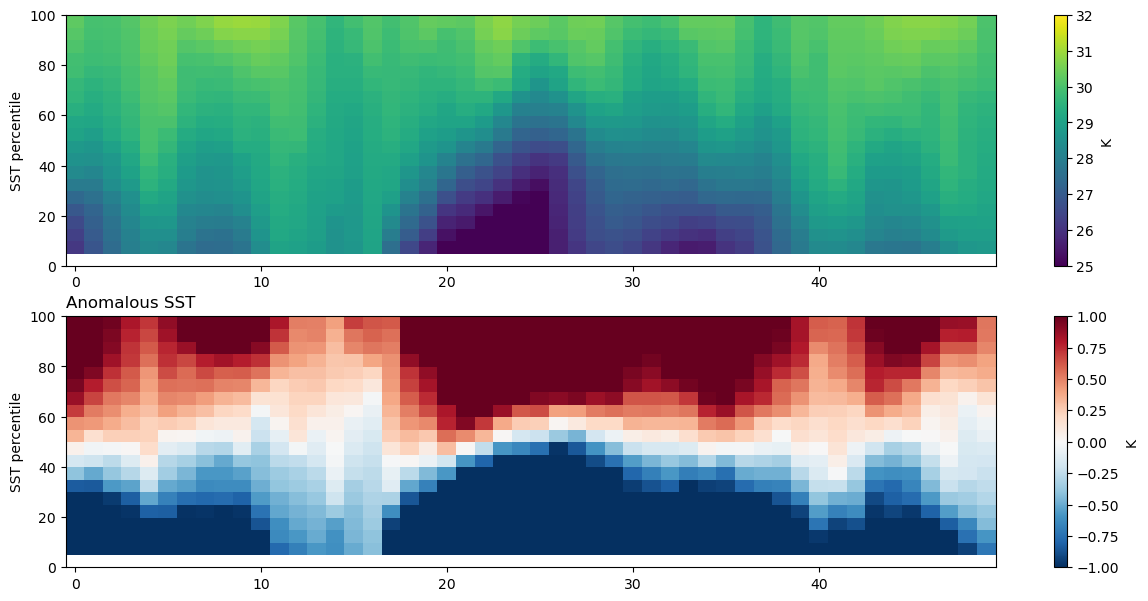

In [64]:
time = np.arange(0,50)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.pcolor(time,prctl_binmids, binavg[:,:-1].T,vmin=25,vmax=32) 
plt.ylabel('SST percentile')
plt.ylim(0,100)
cb=plt.colorbar()
cb.set_label('K')

plt.subplot(412)
means = np.nanmean(binavg, axis=1) 
means = means[np.newaxis, :].T
binanoms = np.subtract(binavg, means)
plt.pcolor(time,prctl_binmids, binanoms[:,:-1].T, vmin=-1,vmax=1,cmap='RdBu_r')
plt.ylabel('SST percentile')
plt.title('Anomalous SST',loc='left') 
cb=plt.colorbar()
cb.set_label('K')